# Project Description:Twitter US Airline Sentiment

# Data Description:

- A sentiment analysis job about the problems of each major U.S. airline.
- Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

# Dataset:

- The project is from a dataset from Kaggle.
- Link to the Kaggle project site:https://www.kaggle.com/crowdflower/twitter-airline-sentiment
- The dataset has to be downloaded from the above Kagglewebsite.

# Objective:

- To implement the techniques learnt as a part of the course.

# Learning Outcomes:
- Basic understanding of text pre-processing.
- What to do after text pre-processing:
    - Bag of words
    - Tf-idf
- Build the classification model.
- Evaluate the Model performance.

In [1]:
# install and import necessary libraries.

!pip install contractions

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import sagemaker
import boto3
from sagemaker.session import s3_input,Session
from sagemaker.amazon.amazon_estimator import get_image_uri

In [3]:
#Get region name for our bucket
bucket_name = 'sahiltweetsdata'
my_region = boto3.session.Session().region_name
print(my_region)

us-west-2


In [4]:
#Connect to s3 bucket
s3 = boto3.resource(
     service_name = 's3',
     region_name = 'us-west-2',
     aws_access_key_id = 'xxxxxxxxx',
     aws_secret_access_key = 'xxxxxxxxx')

In [5]:
for bucket in s3.buckets.all():
    print(bucket.name)

elasticbeanstalk-us-west-2-009940738835
sahiltweetsdata


In [32]:
# Save model back to S3 Bucket again
prefix = 'tf-idf-model'
output_path = 's3://{}/{}/output'.format(bucket_name,prefix)
print(output_path)

s3://sahiltweetsdata/tf-idf-model/output


In [6]:
#Get data from S3 bucket
obj = s3.Bucket('sahiltweetsdata').Object('Tweets.csv').get()
data = pd.read_csv(obj['Body'],index_col=0)

In [7]:
data.shape                                               # print shape of data.

(14640, 14)

In [8]:
data.head(2)                                              # Print first 5 rows of data.


,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


In [9]:
data.isnull().sum(axis=0)                                # Check for NULL values.

airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [10]:
data = data[['text', 'airline_sentiment']]

In [11]:
pd.set_option('display.max_colwidth', None) # Display full dataframe information (Non-turncated Text column.)

data.head()                                 # Check first 5 rows of data
#Qn - What remove ? -> 

,text,airline_sentiment
tweet_id,,
570306133677760513,@VirginAmerica What @dhepburn said.,neutral
570301130888122368,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
570301083672813571,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
570301031407624196,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
570300817074462722,@VirginAmerica and it's a really big bad thing about it,negative


In [12]:
data['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [14]:
#Keep original copy of dataset
data_orig = data.copy()

In [15]:
data = data_orig.copy()

# Data Pre-processing:

- Remove html tags.
- Replace contractions in string. (e.g. replace I'm --> I am) and so on.\
- Remove numbers.
- Tokenization
- To remove Stopwords.
- Lemmatized data
- We have used NLTK library to tokenize words , remove stopwords and lemmatize the remaining words.

In [17]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

data['text'] = data['text'].apply(lambda x: strip_html(x))
data.head()

,text,airline_sentiment
tweet_id,,
570306133677760513,@VirginAmerica What @dhepburn said.,neutral
570301130888122368,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
570301083672813571,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
570301031407624196,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse",negative
570300817074462722,@VirginAmerica and it's a really big bad thing about it,negative


In [18]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

data['text'] = data['text'].apply(lambda x: replace_contractions(x))
data.head()

,text,airline_sentiment
tweet_id,,
570306133677760513,@VirginAmerica What @dhepburn said.,neutral
570301130888122368,@VirginAmerica plus you have added commercials to the experience... tacky.,positive
570301083672813571,@VirginAmerica I did not today... Must mean I need to take another trip!,neutral
570301031407624196,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse",negative
570300817074462722,@VirginAmerica and it is a really big bad thing about it,negative


In [19]:
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

data['text'] = data['text'].apply(lambda x: remove_numbers(x))
data.head()
# Numbers not add value for sentiment analysis

,text,airline_sentiment
tweet_id,,
570306133677760513,@VirginAmerica What @dhepburn said.,neutral
570301130888122368,@VirginAmerica plus you have added commercials to the experience... tacky.,positive
570301083672813571,@VirginAmerica I did not today... Must mean I need to take another trip!,neutral
570301031407624196,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse",negative
570300817074462722,@VirginAmerica and it is a really big bad thing about it,negative


In [20]:
#Remove twitter handles
def strip_twitterhandles(text):
    text = re.sub(r'@\S+', '', text)
    return text

data['text'] = data['text'].apply(lambda x: strip_twitterhandles(x))
data.head()

,text,airline_sentiment
tweet_id,,
570306133677760513,What said.,neutral
570301130888122368,plus you have added commercials to the experience... tacky.,positive
570301083672813571,I did not today... Must mean I need to take another trip!,neutral
570301031407624196,"it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse",negative
570300817074462722,and it is a really big bad thing about it,negative


In [22]:
data['text'] = data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data
data.head(2)    # Look at how tokenized data looks.

,text,airline_sentiment
tweet_id,,
570306133677760513,"[What, said, .]",neutral
570301130888122368,"[plus, you, have, added, commercials, to, the, experience, ..., tacky, .]",positive


In [23]:
stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist))                              

In [24]:
lemmatizer = WordNetLemmatizer()

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

data['text'] = data.apply(lambda row: normalize(row['text']), axis=1)
data.head()



,text,airline_sentiment
tweet_id,,
570306133677760513,say,neutral
570301130888122368,plus add commercials experience tacky,positive
570301083672813571,not today must mean need take another trip,neutral
570301031407624196,really aggressive blast obnoxious entertainment guests face little recourse,negative
570300817074462722,really big bad thing,negative


In [27]:
data.iloc[5]

text                 seriously would pay flight seat not play really bad thing fly va
airline_sentiment                                                            negative
Name: 570300767074181121, dtype: object

In [28]:
X = data['text']
y = data.airline_sentiment


In [29]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train_data, X_test_data, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [30]:
X_train_data.head(2)

tweet_id
569115621213884417    suggestions tell customers approximate wait time hold min allow cancel flight online
569653423836045312           upset hometown airline stick den flt cancel flightled others get new flt info
Name: text, dtype: object

In [33]:
# Add train data into Buckets
import os
bucket_name = 'sahiltweetsdata'
pd.concat([y_train, X_train_data], axis=1).to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

In [34]:
# Add test data into Buckets
bucket_name = 'sahiltweetsdata'
pd.concat([y_train, X_train_data], axis=1).to_csv('test.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/test'.format(bucket_name, prefix), content_type='csv')

In [35]:
# Using TfidfVectorizer to convert text data to numbers.

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train_data)

X_train = X_train.toarray()  

# Build Model using Random Forest

In [36]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import numpy as np

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, X_train, y_train, cv=10)))

RandomForestClassifier(n_estimators=10, n_jobs=4)
0.747266387195122


In [37]:
X_test = vectorizer.transform(X_test_data)
result = forest.predict(X_test)

<AxesSubplot:>

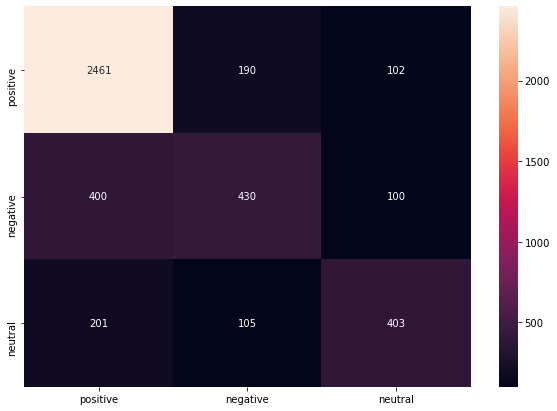

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['positive', 'negative', 'neutral']],
                  columns = [i for i in ['positive', 'negative', 'neutral']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [130]:
import joblib 
joblib.dump(forest, 'classifier.pkl') 
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

In [129]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'Model_Artifacts/classifier.pkl')).upload_file('classifier.pkl')
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'Model_Artifacts/vectorizer.pkl')).upload_file('vectorizer.pkl')